In [1]:
#!pip install -r requirements.txt

INFO: pip is looking at multiple versions of tensorboard-plugin-wit to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
INFO: pip is looking at multiple versions of tensorboard-data-server to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl (6.6 MB)
INFO: pip is looking at multiple versions of tensorboard to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
INFO: pip is looking at multiple versions of starlette to determine which version is compatible with other requirements. This could take a while.
  Using cached starlette-0.37.2-py3-none-any.whl (71 kB)
INFO: pip is looking at multiple versions of stack-data to determine which version is compatible with other req

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
from datetime import datetime
import time
import cv2
import pandas as pd
import math

import tensorflow as tf
print(tf.__version__)

from keras.applications import EfficientNetB0
from keras.models import Model, Sequential
from keras import layers
from keras import callbacks
#from keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
#from keras.optimizers import Adam, RMSprop

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import funcs as f
import im_utils

2024-06-30 22:59:54.750390: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-30 22:59:54.822549: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-30 22:59:54.824095: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 22:59:56.225027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.0


In [3]:
#from keras.callbacks import EarlyStopping
class CustomStopper(callbacks.EarlyStopping):
    def __init__(self, monitor='val_loss',
             patience=5, verbose=0, mode='auto', start_epoch = 10, restore_best_weights=True): # add argument for starting epoch
        super(CustomStopper, self).__init__()
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

In [4]:
SIZE = 254 #Size of the images this model will deal with
IMDIM = 3
IMG_SIZE = (SIZE, SIZE)            # Define the image size
INPUT_SHAPE = (*IMG_SIZE, IMDIM)       # Define the input_shape

Filters = 16
BATCH_SIZE = 128
EPOCHS = 100
TEST_SIZE = 0.3   # Validation/Train split ratio

RAND_SEED  = 42 # The answer to the ultimate question of life, the universe, and everything

In [5]:
path = './branded/'
#os.system(f"aws s3 cp {'s3://open-logo-s3/branded/'} {path} --recursive")  

#### Read the file names and labeles

In [6]:
# this list holds all the image filename
boxes_file_paths = []
labels = []

# reads paths for each image and stores it in the array, also stores the label in a separate array
for path_tuple in os.walk(path):
    for file in path_tuple[2]:
        if file.endswith(".jpg"):
            boxes_file_paths.append(os.path.join(path_tuple[0], file))
            labels.append(path_tuple[0].split('/')[-1])

#### Prepare a dataframe of filenames and labels

In [7]:
# Convert labels to dataframe
lbl_df = pd.DataFrame(labels, columns=['label'])

# Get a new data frame with the counts of each lable
counts = lbl_df.groupby('label').value_counts().sort_values(ascending=False).to_frame()
counts['brand_name'] = counts.index

In [8]:
# Get the brand info from the datbase
import db_ops
query = f'''
SELECT *
FROM brand
ORDER BY brand_name DESC
'''
brand_df = db_ops.select_to_pandas(query, True, True)

Connecting to the PostgreSQL database...
Connection successful


/home/art_usr/source_code/litter-imagery-brand-recognition/db_ops.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [9]:
counts = counts.set_index('brand_name').join(brand_df.set_index('brand_name')).sort_values('brand_name')
counts['idx'] = range(len(counts))

In [10]:
counts.to_csv('brand_ids_idx.csv', sep = '\t')
counts.sort_values('count', ascending=False).head(50)

,count,brand_id,score,idx
brand_name,,,,
corona,977,32,36.38350,46
heineken,892,53,21.66269,84
modelo,386,71,4.58534,125
bud_light,256,137,0.00000,26
coca_cola,135,29,3.77853,43
pepsi,89,81,1.53629,150
red_bull,71,83,1.26399,163
gatorade,66,47,2.94483,71
seven_eleven,49,88,0.41349,174


In [11]:
# Associate uniqe numeric index with the brand and, consequently, the file
lbl_df['idx'] = lbl_df['label'].apply(lambda x: counts['idx'].loc[x])

# Add the path to the df
lbl_df['file_path'] = boxes_file_paths

# Shuffle the dataframe
lbl_df = lbl_df.sample(frac=1).reset_index(drop=True)
lbl_df

,label,idx,file_path
0,corona,46,./branded/corona/im.jpg1425.jpg
1,heineken,84,./branded/heineken/im.jpg6811.jpg
2,corona,46,./branded/corona/im.jpg1977.jpg
3,heineken,84,./branded/heineken/im.jpg8588.jpg
4,corona,46,./branded/corona/ordered_866_im.jpg8983.jpg
...,...,...,...
4042,heineken,84,./branded/heineken/im.jpg9499.jpg
4043,corona,46,./branded/corona/im.jpg9556.jpg
4044,heineken,84,./branded/heineken/im.jpg2031.jpg
4045,heineken,84,./branded/heineken/ordered_2554_ordered_966_im...


In [12]:
# Get a dataframe with a list of all paths for each label
new_df = lbl_df.groupby('idx')['file_path'].apply(list).reset_index()
new_df.head(3)

,idx,file_path
0,0,[./branded/100_grand/ordered_1106_ordered_1885...
1,1,"[./branded/1800/ordered_1552_im.jpg203.jpg, ./..."
2,2,[./branded/3_musketeers/ordered_131_ordered_19...


In [13]:
# Set the number of categories
num_classes = len(counts)
num_classes

223

#### Read the files/labels and convert them into the right shape

In [14]:
# Make an array of the images
import random
X = []
y_dense = []
for idx in range(len(new_df)):
    counter = 0
    for file_path in new_df['file_path'].iloc[idx]:
        # Read the image
        img_orig = cv2.imread(file_path, cv2.IMREAD_COLOR)
        img = im_utils.resize_to_size(img_orig, SIZE)
        img = im_utils.crop_to_square(img)
        X.append(img)
        y_dense.append(idx)
        counter += 1
    while counter < 10:
        # Select a random image for this index
        img_index = random.randint(0, len(new_df['file_path'].iloc[idx])-1)
        file_path = new_df['file_path'].iloc[idx][img_index]
        img_orig = cv2.imread(file_path, cv2.IMREAD_COLOR)
        # Roatate this image by a random angle
        angle = random.randint(1, 180)
        img = im_utils.rotate_and_crop(img_orig, angle)
        # Randomly change the brightness of this image
        brightness = 10 * random.randint(0, 20) # Need sizable change, no less than 10 points
        img = im_utils.jitter_brightness(img, brightness )
        X.append(img)
        y_dense.append(idx)
        counter += 1


X = np.array(X)
X.shape

y = to_categorical(y_dense, num_classes=num_classes)
y.shape

(5452, 223)

#### Read the labels

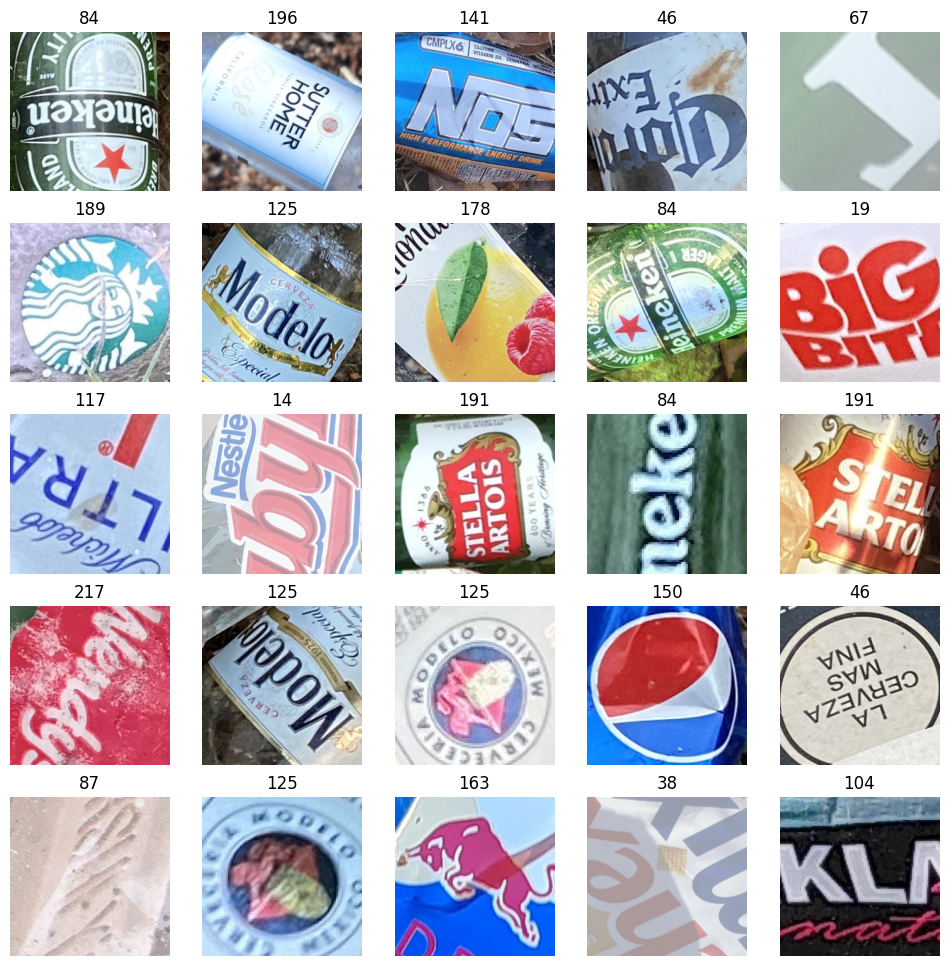

In [18]:
# Visualize random 25 images to make sure it makes sense
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = np.random.choice(np.arange(len(y)))
    axs[i,j].imshow(cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB))
    axs[i,j].set_title(y_dense[idx])
    axs[i,j].axis('off')

plt.show()

# Make sure all images are square, undistorted, labels make sense

In [19]:
def build_model(num_classes):
    inputs = layers.Input(shape=INPUT_SHAPE)
    EffNet_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    EffNet_model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(EffNet_model.output)
    x = layers.BatchNormalization(name="batch_norm")(x)
    x = layers.Dense(4*num_classes, activation="relu", name="NN1")(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

early_stopping = CustomStopper()

In [20]:
from sklearn.model_selection import train_test_split

# Get the names of the files that will be used for both thresholded and non-thresholded images
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2024-06-30 23:02:58.537384: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 738579168 exceeds 10% of free system memory.
2024-06-30 23:02:59.886890: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 316644528 exceeds 10% of free system memory.


In [21]:
#Define the model
model = build_model(num_classes)

In [22]:
# Train the model with the early stopping callback
print("Training model...")
start_time = time.time()
history = model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose = 2, callbacks = [early_stopping])
end_time = time.time()
print(f"Training took {end_time - start_time:.2f} seconds")

Training model...


2024-06-30 23:03:14.019499: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 738579168 exceeds 10% of free system memory.


Epoch 1/100


2024-06-30 23:03:24.115059: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 99096576 exceeds 10% of free system memory.
2024-06-30 23:03:24.374242: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 99878400 exceeds 10% of free system memory.


KeyboardInterrupt: 

In [46]:
# Save results
p = os.getcwd()
model_dir = os.path.join(p, 'B0_custaug_model', 'B0_custaug_model.keras')
model.save(model_dir)

result_dir = os.path.join(p, 'B0_custaug_results')

50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step


<Axes: >

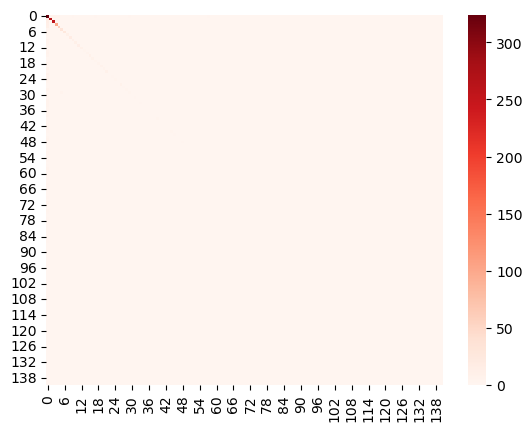

In [47]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay
import seaborn as sns

y_true = np.argmax(y_val, axis=1)
y_pred = model.predict(X_val)

y_pred_dense = np.argmax(y_pred, axis=1)
#f1 = f1_score(y_true, y_pred_dense, average='weighted')
accuracy = accuracy_score(y_true, y_pred_dense)
#recall = recall_score(y_true, y_pred_dense)

convergence = history.history['loss'][-1]

#Plot confusion matrics
cm = confusion_matrix(y_true, y_pred_dense)
sns.heatmap(cm, fmt='', cmap='Reds')

In [48]:
print(f"accuracy: {round (100* accuracy, 2)}, convergence : {round(convergence, 4)}")

accuracy: 76.91, convergence : 0.08
